In [1]:
import seaborn as sns
import matplotlib 

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.dates as mdates

import math
from sys import path
path.append('..//modules')
path.append('..//dumps//reg_dmo_pdf')
import time
import pandas as pd
import psycopg2 as pg
from geoalchemy2 import Geometry, WKTElement
from sqlalchemy import create_engine, MetaData, Table
import pandas.io.sql as psql

#create a postgres engine and a pg connection
from modules.db_connector import *
print("DB connecting engine imported")


#print(matplotlib.rcParams.keys())

font = {'family' : 'Roboto', 
        'weight': '300',
        'size'   : 20}


axesfoo = {'labelweight': '300'}
#unified_colors
clr_mean = "red"
clr_mode = "black"
clr_median = "orange"

import matplotlib 
matplotlib.rc('font', **font)
matplotlib.rc('axes', **axesfoo)

#https://medium.com/dunder-data/automatically-wrap-graph-labels-in-matplotlib-and-seaborn-a48740bc9ce
import textwrap
def wrap_labels(ax, width, break_long_words=False):
    labels = []
    for label in ax.get_xticklabels():
        text = label.get_text()
        labels.append(textwrap.fill(text, width=width,
                      break_long_words=break_long_words))
    ax.set_xticklabels(labels, rotation=0)

    


DB connecting engine imported


In [129]:
with engine.connect() as con1:
    q = """
    select * , to_date(visit_month || '-' ||visit_year, 'Mon-Year') dd,
    case 
        when visit_month in ('Dec', 'Jan', 'Feb') THEN 'Winter'
        when visit_month in ('Mar', 'Apr', 'May') THEN 'Spring'
        when visit_month in ('Jun', 'Jul', 'Aug') THEN 'Summer'
        when visit_month in ('Sep', 'Oct', 'Nov') THEN 'Fall'
        else null end season,
    case 
        when visit_month in ('Jan', 'Feb', 'Mar') THEN 1
        when visit_month in ('Apr', 'May', 'Jun') THEN 2
        when visit_month in ('Jul', 'Aug', 'Sep') THEN 3
        when visit_month in ('Oct', 'Nov', 'Dec') THEN 4
        else null end qrt
        
from gtlab.sk_ta_geosites_reviews 
where visit_month <> 'n/a'
    """
    

    q1 = "select * from  gtlab.ta_reviewers_origin where reviewer_origin not in ('n/a', '') and lat is null;"
    q2 = "select * from  gtlab.ta_reviewers_origin where ggl_country is not null or ggl_country <> 'n/a';"
    df_gp_ann_agg = pd.read_sql(q, con=con1)
    df_rev_origins = pd.read_sql(q1, con=con1)
    df_rev_gcd_origins = pd.read_sql(q2, con=con1)

    con1.close()
    
df_gp_ann_agg['Date'] = pd.to_datetime(df_gp_ann_agg['dd'], format='%Y-%m-%d')

dfg1 = pd.pivot_table(df_gp_ann_agg, index = ['visit_year', 'visit_month'], values = 'poi_id', aggfunc='count')
dfg1 = dfg1.reset_index()

dfg3 = pd.pivot_table(df_gp_ann_agg, index = ['visit_year', 'visit_month', 'Date', 'season', 'qrt'], values = 'poi_id', aggfunc='count')
dfg3 = dfg3.reset_index()
dfg3 = dfg3.sort_values(by='Date')

dfg3['int_month'] = [x.month for x in dfg3['Date'] ]

dfg3a = dfg3[['Date','poi_id']]

C:\Users\csb\anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\csb\AppData\Local\Temp\ipykernel_17340\1275017325.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(g1.get_xticklabels(), rotation=90)
C:\Users\csb\anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\csb\anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.opti

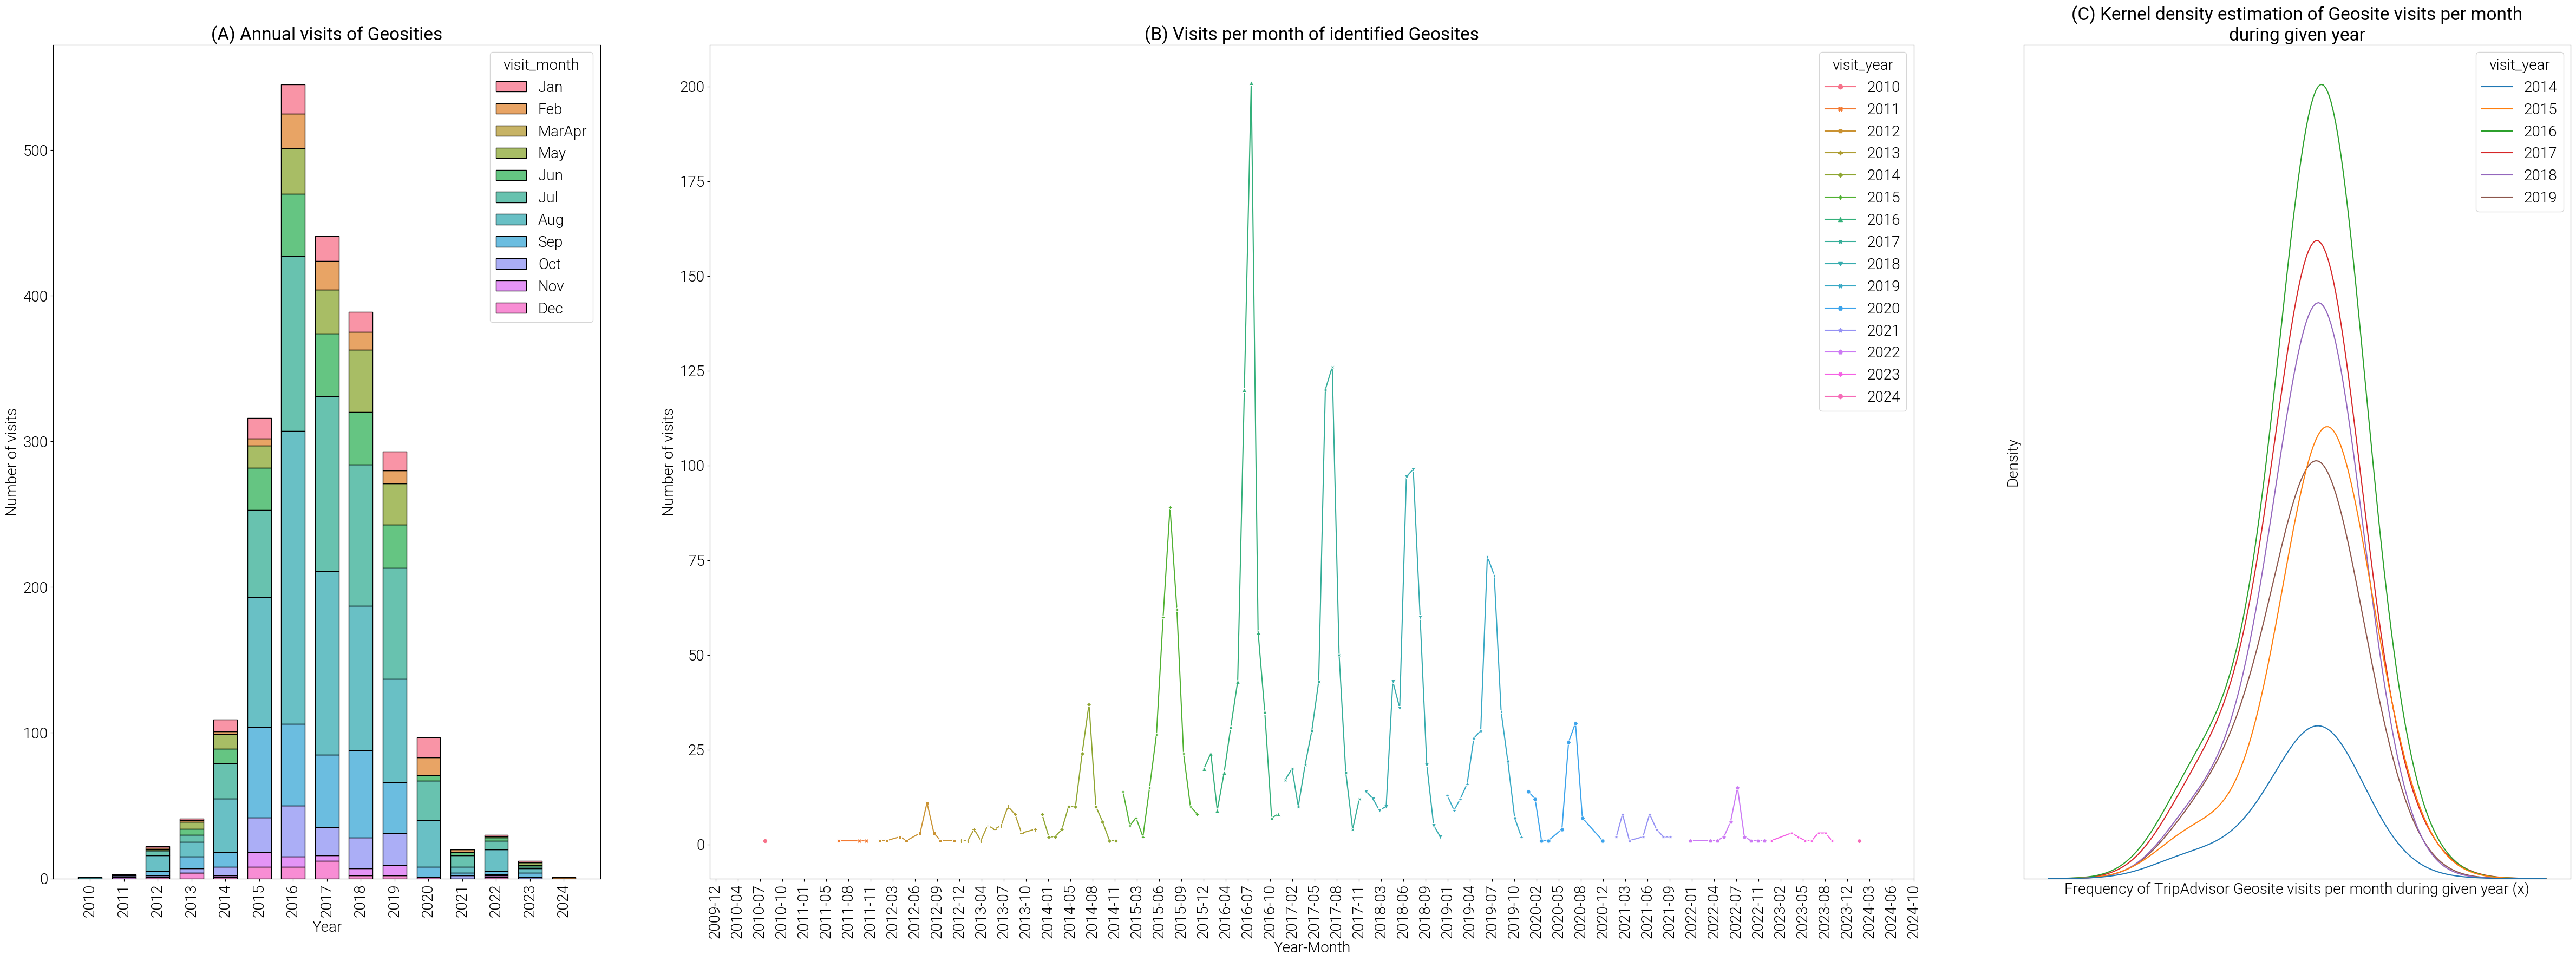

In [130]:
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime


fig = plt.figure(figsize=(60, 20))
gs = GridSpec(1, 4, figure=fig)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1:3])
ax3 = fig.add_subplot(gs[0, 3])


g1_hueorder = ['Jan','Feb', 'Mar' 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']   
g1 = sns.histplot(data= dfg1, x = "visit_year", weights='poi_id', hue='visit_month', hue_order = g1_hueorder, multiple="stack", shrink=0.7,ax=ax1)
#g1.xaxis.set_major_locator(plt.MaxNLocator(15))
ax1.set_xticklabels(g1.get_xticklabels(), rotation=90)
ax1.set(title="\n".join(textwrap.wrap("(A) Annual visits of Geosities",60)))
ax1.set(xlabel='Year', ylabel='Number of visits')


#style='qrt', style_order=style_ord,
style_ord = [1, 2, 3, 4 ]
g2 = sns.lineplot(data = dfg3, x ="Date", y='poi_id', hue='visit_year', markers=True, style = 'visit_year', dashes=False, ax=ax2)
g2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
#g3.xaxis.set_major_locator(mdates.YearLocator())
g2.xaxis.set_major_locator(mdates.MonthLocator())
g2.xaxis.set_major_locator(plt.MaxNLocator(64))
ax2.set_xticklabels(g2.get_xticklabels(), rotation=90)
ax2.set(title="\n".join(textwrap.wrap("(B) Visits per month of identified Geosites",60)))
ax2.set(xlabel='Year-Month', ylabel='Number of visits')



years_full_month = ['2014', '2015', '2016', '2017', '2018', '2019']
g3 = sns.kdeplot(data= dfg3.query('visit_year  in @years_full_month'), x='int_month', weights ='poi_id', hue='visit_year', ax=ax3)
ax3.tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)
ax3.set(xlabel='Frequency of TripAdvisor Geosite visits per month during given year (x)', ylabel='Density')
ax3.set(title="\n".join(textwrap.wrap("(C) Kernel density estimation of Geosite visits per month during given year",60)))
        
#g1 = sns.histplot(data=df_gp_ann_agg, x = "my", weights='n', kde=False,shrink = 0.7, ax=ax1)
#ax1.set_xticklabels(g1.get_xticklabels(), rotation=90)

plt.savefig("dumps/exported_figs/grid_geosites_rev_timeline.svg", bbox_inches="tight")


In [100]:
from scipy.stats import skew, kurtosis
dfg3.query('visit_year  in @years_full_month')

years_full_month = ['2014', '2015', '2016', '2017', '2018', '2019']


skew14 = dfg3.query('visit_year  in @years_full_month')['poi_id']

skews = []
kurts = []

for y in years_full_month:
    skew_y = skew(dfg3.query('visit_year == @y')['poi_id'])
    kurt_y = kurtosis(dfg3.query('visit_year == @y')['poi_id'])
    skews.append(skew_y)
    kurts.append(kurt_y)
    
    

In [103]:
kurts

[1.98348725464421,
 0.0378984240502831,
 2.260608157110121,
 0.5246820111549302,
 -0.3499977246927024,
 -0.04563096488820495]

In [93]:
import datetime
from dateutil.rrule import rrule, MONTHLY

#2010-08-01
#2024-02-01

dates = [dt for dt in rrule(MONTHLY, dtstart=, until=.max())]
len(dates)

163

In [4]:
df_un_geo = pd.read_excel('C:\\Users\\csb\\Desktop\\notes\\ta_senti_geo_pa_dmo\\dumps\\input\\unsd_geoscheme.xlsx', sheet_name='Sheet1')

un_countries = list(df_un_geo['country'])
un_geo_regions = list(df_un_geo['geo_region'])
un_continent = list(df_un_geo['continent'])



for i, ggl_country in zip(df_rev_gcd_origins.index, df_rev_gcd_origins['ggl_country']):
    if ggl_country in un_countries:
        #print(ggl_country, un_countries[un_countries.index(ggl_country)], un_geo_regions[un_countries.index(ggl_country)], un_continent[un_countries.index(ggl_country)])
        update_query = "UPDATE gtlab.ta_reviewers_origin set continent ='" + un_continent[un_countries.index(ggl_country)] + "', un_geo_region = '"+un_geo_regions[un_countries.index(ggl_country)] + "' where ggl_country = '" +ggl_country+"';"       
        with engine.connect() as con1:
            con1.execute(text(update_query))
            con1.commit()
            con1.close()
        print(i)
    else:
            pass

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
74
75
76
77
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278


In [21]:
df_rev_gcd_origins

,reviewer_origin,array_poi_ids,lat,lon,ggl_address,ggl_location_type,ggl_place_id
0,"Norwich, UK","[g982822-d8549787, g274942-d6439669]",52.6292567,1.2978802,"Norwich, UK",APPROXIMATE,ChIJE_UzUdWq0EcRL0USDuClTGg
1,"Nagano, Japan",[g982822-d8549787],36.6485258,138.1950371,"Nagano, Japan",APPROXIMATE,ChIJmUQ05l2AHWARyJIoB3SpKPE
2,"Namestovo, Slovakia","[g274942-d6439669, g799594-d8544722]",49.404472,19.4812155,"029 01 Námestovo, Slovakia",APPROXIMATE,ChIJ_Y6fp-vIFUcRtiSot8hXTgI
3,"Napajedla, Czech Republic",[g274929-d1930970],49.1715578,17.5119527,"763 61 Napajedla, Czechia",APPROXIMATE,ChIJWUQOmAoSE0cRaGn_H1mLDxM
4,"Netanya, Israel",[g612452-d547433],32.321458,34.853196,"Netanya, Israel",APPROXIMATE,ChIJ1XXAkwRAHRURIj88VL6V2Sw
...,...,...,...,...,...,...,...
745,"Moravka, Czech Republic",[g982822-d8549787],49.5960692,18.5247241,"739 04 Morávka-Pražmo, Czechia",APPROXIMATE,ChIJKycZJBAMFEcRA6-wZ6Ove84
746,"Moscow Oblast, Russia","[g982822-d8549787, g274929-d3190440]",55.340396,38.2917651,"Moscow Oblast, Russia",APPROXIMATE,ChIJ2cXDsDGySkERQvLeO8CzDJE
747,"Moscow, Russia","[g6952937-d6952269, g277810-d4312850, g1028715...",55.755826,37.6173,"Moscow, Russia",APPROXIMATE,ChIJybDUc_xKtUYRTM9XV8zWRD0
748,"Mumbai, India",[g982822-d8549787],19.0759837,72.8776559,"Mumbai, Maharashtra, India",APPROXIMATE,ChIJwe1EZjDG5zsRaYxkjY_tpF0


In [114]:
#!/usr/bin/env python3 
from sys import path
path.append('..//modules')
from modules.db_connector import *
from datetime import datetime
import googlemaps
gmaps = googlemaps.Client(key='YOUR GGL MAPS KEY')

#https://github.com/googlemaps/google-maps-services-python

import requests
import json
import pandas as pd
import numpy as np
from pprint import pprint
from datetime import datetime
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1500)
startTime = datetime.now()
import pandas.io.sql as psql
import psycopg2 as pg
from sqlalchemy import create_engine, MetaData, Table, text
import time





def ggl_gcd_adrs(df_in):
    for i, reviewer_origin in zip(df_in.index, df_in['reviewer_origin']):
        time.sleep(0.3)
        print("Working on " + reviewer_origin + ", " + str(i) + " of " + str(len(df_in)))
        #geocode_result = gmaps.geocode('1600 Amphitheatre Parkway, Mountain View, CA')
        l_json = gmaps.geocode(reviewer_origin)
        try:
            lat = l_json[0]['geometry']['location']['lat']
            lon = l_json[0]['geometry']['location']['lng']
            ggl_location_type = l_json[0]['geometry']['location_type']
            ggl_address = l_json[0]['formatted_address']
            if "'" in ggl_address:
                print(ggl_address)
                new_ggl_address = ggl_address.replace("'", " ")
                print(new_ggl_address)
            else: 
                new_ggl_address = ggl_address
            ggl_place_id = l_json[0]['place_id'] 
            print(new_ggl_address)
            
            admin_types = []
            for admtype in l_json[0]['address_components']:
                admin_types.append(admtype['types'][0])

            if 'locality' not in admin_types:
                ggl_locality = 'n/a'
            elif 'locality' in admin_types:
                for ele in l_json[0]['address_components']:
                    if ele['types'][0] == 'locality':
                        ggl_localilty = ele['long_name'].replace("'", " ")
                        print(ggl_localilty)
            if 'administrative_area_level_1' not in admin_types:
                ggl_admin_level1 = 'n/a'
            elif 'administrative_area_level_1' in admin_types:
                for ele in l_json[0]['address_components']:
                    if ele['types'][0] == 'administrative_area_level_1':
                        ggl_admin_level1 = ele['long_name'].replace("'", " ")
            if 'administrative_area_level_2' not in admin_types:
                ggl_admin_level2 = 'n/a'
            elif 'administrative_area_level_2' in admin_types:
                for ele in l_json[0]['address_components']:
                    if ele['types'][0] == 'administrative_area_level_2':
                        ggl_admin_level2 = ele['long_name'].replace("'", " ")
            if 'country' not in admin_types:
                ggl_country = 'n/a'
            elif 'country' in admin_types:
                for ele in l_json[0]['address_components']:
                    if ele['types'][0] == 'country':
                        ggl_country = ele['long_name'].replace("'", " ")
        
            update_query = "UPDATE gtlab.ta_reviewers_origin set lat ='" + str(lat) + "', lon = '" + str(lon) + "', ggl_address = '" + new_ggl_address + "', ggl_location_type = '" + ggl_location_type +"', ggl_place_id = '" + ggl_place_id + "',  ggl_country ='" + ggl_country +"', ggl_locality = '"+ggl_localilty +"', ggl_admin_level1 = '" + ggl_admin_level1 +"', ggl_admin_level2 = '" + ggl_admin_level2 + "'  where reviewer_origin = '" +reviewer_origin+"';"       
            with engine.connect() as con1:
                con1.execute(text(update_query))
                con1.commit()
                con1.close()
        except IndexError:
            pass
            
ggl_gcd_adrs(df_rev_origins)

Working on Aalborg, Denmark, 0 of 750
Aalborg, Denmark
Aalborg
Working on Aarhus, Denmark, 1 of 750
Aarhus, Denmark
Aarhus
Working on Abu Dhabi, United Arab Emirates, 2 of 750
Abu Dhabi - United Arab Emirates
Abu Dhabi
Working on Adelaide, 3 of 750
Adelaide SA, Australia
Working on Albacete, Spain, 4 of 750
Albacete, Spain
Albacete
Working on Algeciras, Spain, 5 of 750
Algeciras, Cádiz, Spain
Algeciras
Working on Almelo, The Netherlands, 6 of 750
Almelo, Netherlands
Almelo
Working on Amiens, France, 7 of 750
Amiens, France
Amiens
Working on Amsterdam, The Netherlands, 8 of 750
Amsterdam, Netherlands
Amsterdam
Working on Ankara, Türkiye, 9 of 750
Ankara, Türkiye
Ankara
Working on Antwerp, Belgium, 10 of 750
Antwerp, Belgium
Antwerp
Working on Arkhangelsk, Russia, 11 of 750
Arkhangelsk, Arkhangelsk Oblast, Russia
Arkhangelsk
Working on Assen, The Netherlands, 12 of 750
Assen, Netherlands
Assen
Working on Atlanta, GA, 13 of 750
Atlanta, GA, USA
Atlanta
Working on Australia, 14 of 750
Aust

Working on Cincinnati Ohio, 110 of 750
Cincinnati, OH, USA
Cincinnati
Working on Clermont-Ferrand, France, 111 of 750
Clermont-Ferrand, France
Clermont-Ferrand
Working on Cleveland, OH, 112 of 750
Cleveland, OH, USA
Cleveland
Working on Cluj, 113 of 750
Cluj-Napoca, Romania
Cluj-Napoca
Working on Cluj-Napoca, Romania, 114 of 750
Cluj-Napoca, Romania
Cluj-Napoca
Working on Colchester, UK, 115 of 750
Colchester, UK
Colchester
Working on Colorado, 116 of 750
Colorado, USA
Working on Colorado Springs, CO, 117 of 750
Colorado Springs, CO, USA
Colorado Springs
Working on Columbia, MD, 118 of 750
Columbia, MD, USA
Columbia
Working on Copenhagen, Denmark, 119 of 750
Copenhagen, Denmark
Copenhagen
Working on Corfu, Greece, 120 of 750
Corfu, Greece
Working on Cork, Ireland, 121 of 750
Cork, Ireland
Cork
Working on Cormano, Italy, 122 of 750
20032 Cormano, Metropolitan City of Milan, Italy
Cormano
Working on Cotonou, Benin, 123 of 750
Cotonou, Benin
Cotonou
Working on cottbus, 124 of 750
03 Cottb

Working on Hazlet, NJ, 225 of 750
Hazlet, NJ, USA
Hazlet
Working on Heemskerk, The Netherlands, 226 of 750
Heemskerk, Netherlands
Heemskerk
Working on Hellerup, Denmark, 227 of 750
Hellerup, Denmark
Hellerup
Working on Herzlia, Israel, 228 of 750
Herzliya, Israel
Herzliya
Working on Herzliya, Israel, 229 of 750
Herzliya, Israel
Herzliya
Working on Hillegom, The Netherlands, 230 of 750
Hillegom, Netherlands
Hillegom
Working on Hilversum, The Netherlands, 231 of 750
Hilversum, Netherlands
Hilversum
Working on Hlohovec, Slovakia, 232 of 750
Hlohovec, Slovakia
Hlohovec
Working on Hod Hasharon, Israel, 233 of 750
Hod Hasharon, Israel
Hod Hasharon
Working on Holbaek, Denmark, 234 of 750
Holbæk, Denmark
Holbæk
Working on Holon, Israel, 235 of 750
Holon, Israel
Holon
Working on Holon, Tel Aviv, Israel, 236 of 750
Holon Wolfson, Tel Aviv-Yafo, Israel
Tel Aviv-Yafo
Working on Hoofddorp, The Netherlands, 237 of 750
Hoofddorp, Netherlands
Hoofddorp
Working on Horna Lehota, Slovakia, 238 of 750
Hor

Working on Liptovsky Hradok, Slovakia, 336 of 750
033 01 Liptovský Hrádok, Slovakia
Liptovský Hrádok
Working on Liptovsky Mikulas, Slovakia, 337 of 750
Liptovský Mikuláš, Slovakia
Liptovský Mikuláš
Working on Lisbon, Portugal, 338 of 750
Lisbon, Portugal
Lisbon
Working on Liskeard, UK, 339 of 750
Liskeard PL14, UK
Liskeard
Working on Lisnyky, Ukraine, 340 of 750
Lisnyky, Ternopil Oblast, Ukraine, 47543
Lisnyky
Working on Litomysl, Czech Republic, 341 of 750
570 01 Litomysl-Litomyšl, Czechia
Litomysl
Working on Litvinov, Czech Republic, 342 of 750
Litvínov, Czechia
Litvínov
Working on Lod, Israel, 343 of 750
Lod, Israel
Lod
Working on Lodz, Poland, 344 of 750
Łódź, Poland
Łódź
Working on Lomnice, Czech Republic, 345 of 750
356 01 Lomnice-Sokolov 1, Czechia
Lomnice
Working on london, 346 of 750
London, UK
London
Working on London, Canada, 347 of 750
London, ON, Canada
London
Working on London, UK, 348 of 750
London, UK
London
Working on London, United Kingdom, 349 of 750
London, UK
Londo

Working on Odesa, Ukraine, 444 of 750
Odesa, Odesa Oblast, Ukraine, 65000
Odesa
Working on Oldenburg, Germany, 445 of 750
26 Oldenburg, Germany
Oldenburg
Working on Olomouc, 446 of 750
Olomouc, Czechia
Olomouc
Working on Olomouc Region, Czech Republic, 447 of 750
Olomouc Region, Czechia
Working on Olomouc, Czech Republic, 448 of 750
Olomouc, Czechia
Olomouc
Working on Olsztyn, Poland, 449 of 750
Olsztyn, Poland
Olsztyn
Working on Omsk, Russia, 450 of 750
Omsk, Omsk Oblast, Russia
Omsk
Working on Opava, Czech Republic, 451 of 750
Opava, Czechia
Opava
Working on Opole, Poland, 452 of 750
Opole, Poland
Opole
Working on Or yehuda, 453 of 750
Or Yehuda, Israel
Or Yehuda
Working on Orange, France, 454 of 750
84100 Orange, France
Orange
Working on Ordizia, Spain, 455 of 750
Ordizia, Gipuzkoa, Spain
Ordizia
Working on Orebro, Sweden, 456 of 750
Örebro, Sweden
Örebro
Working on Orlando, FL, 457 of 750
Orlando, FL, USA
Orlando
Working on Orlova, Czech Republic, 458 of 750
Orlová, Czechia
Orlová


Working on San Francisco, CA, 555 of 750
San Francisco, CA, USA
San Francisco
Working on San Mauro a Mare, Italy, 556 of 750
47030 San Mauro Mare, Province of Forlì-Cesena, Italy
San Mauro Mare
Working on Sant Quirze del Valles, Spain, 557 of 750
Sant Quirze del Vallès, Barcelona, Spain
Sant Quirze del Vallès
Working on Sao Paulo, SP, 558 of 750
São Paulo, State of São Paulo, Brazil
São Paulo
Working on Sastin-Straze, Slovakia, 559 of 750
908 41 Šaštín-Stráže, Slovakia
Šaštín-Stráže
Working on savyon, 560 of 750
Savyon, Israel
Savyon
Working on Savyon, Israel, 561 of 750
Savyon, Israel
Savyon
Working on Seattle, WA, 562 of 750
Seattle, WA, USA
Seattle
Working on Sebnitz, Germany, 563 of 750
01 Sebnitz, Germany
Sebnitz
Working on Senec, Slovakia, 564 of 750
903 01 Senec, Slovakia
Senec
Working on Senica, Slovakia, 565 of 750
905 01 Senica, Slovakia
Senica
Working on Shizuoka Prefecture, Japan, 566 of 750
Shizuoka, Japan
Working on Siauliai, Lithuania, 567 of 750
Šiauliai, Šiauliai City 

Working on Ukraine, 668 of 750
Ukraine
Working on United Arab Emirates, 669 of 750
United Arab Emirates
Working on United Kingdom, 670 of 750
United Kingdom
Working on Usti nad Labem, Czech Republic, 671 of 750
Ústí nad Labem, Czechia
Ústí nad Labem
Working on Utrecht, The Netherlands, 672 of 750
Utrecht, Netherlands
Utrecht
Working on Valasska Bystrice, Czech Republic, 673 of 750
756 27 Valašská Bystřice, Czechia
Valašská Bystřice
Working on Valasske Mezirici, Czech Republic, 674 of 750
Valasske Mezirici, Czechia
Valasske Mezirici
Working on Valencia, Spain, 675 of 750
Valencia, Spain
Valencia
Working on Valparaiso, Indiana, United States, 676 of 750
Valparaiso, IN, USA
Valparaiso
Working on Vancouver, Canada, 677 of 750
Vancouver, BC, Canada
Vancouver
Working on Vancouver, WA, 678 of 750
Vancouver, WA, USA
Vancouver
Working on Västerås, Sweden, 679 of 750
Västerås, Sweden
Västerås
Working on Vaxjo, Sweden, 680 of 750
Växjö, Sweden
Växjö
Working on Veendam, The Netherlands, 681 of 750

In [133]:
with engine.connect() as con1:
    q_ndx = """
   with foo as (
select * from gtlab.sk_ta_geosites_reviews 
left join gtlab.ta_reviewers_origin using (reviewer_origin)
)
(select 'root'::text lvl, 'Origin of reviewers' from_node, 'Origin of reviewers' to_node, count(*) n from foo)
union all
(select 'lvl1'::text lvl, 'Origin of reviewers' from_node, continent to_node, count(*) n from foo group by to_node order by continent)
union all
(select 'lvl2'::text lvl, continent from_node, un_geo_region to_node, count(*) n from foo where un_geo_region <> 'N/a' and  ggl_country <> 'Unknown' group by from_node, to_node order by from_node, to_node)
union all
(select 'lvl3'::text lvl, un_geo_region from_node, ggl_country to_node, count(*) n from foo where un_geo_region <> 'N/a' and  ggl_country <> 'Unknown' group by from_node, to_node order by from_node, to_node)

"""
    q_med_cntr = """
    with foo as (
select * from gtlab.sk_ta_geosites_reviews 
left join gtlab.ta_reviewers_origin using (reviewer_origin)
)
    select ggl_country, count(*) n from foo group by ggl_country; 
    """
    df_ndx = pd.read_sql(q_ndx, con=con1)
    df_desc = pd.read_sql(q_ndx, con=con1)

    df_cnt = pd.read_sql(q_med_cntr, con=con1)

    con1.close()
    
for i, from_node in zip(df_ndx.index, df_ndx['from_node']):
    if len(from_node.split(' ')) > 1:
        wrap_from = max([len(x) for x in from_node.split(' ')])
        df_ndx.loc[i, 'from_node'] = "\n".join(textwrap.wrap(from_node, wrap_from))
    
    
for i, to_node in zip(df_ndx.index, df_ndx['to_node']):
    if len(to_node.split(' ')) > 1:
        wrap_to = max([len(x) for x in to_node.split(' ')])
        df_ndx.loc[i, 'to_node'] = "\n".join(textwrap.wrap(to_node, wrap_to))

In [134]:
hex_limits = [1, 5, 25, 50, 100, 500, 1000, 1500, 2000]

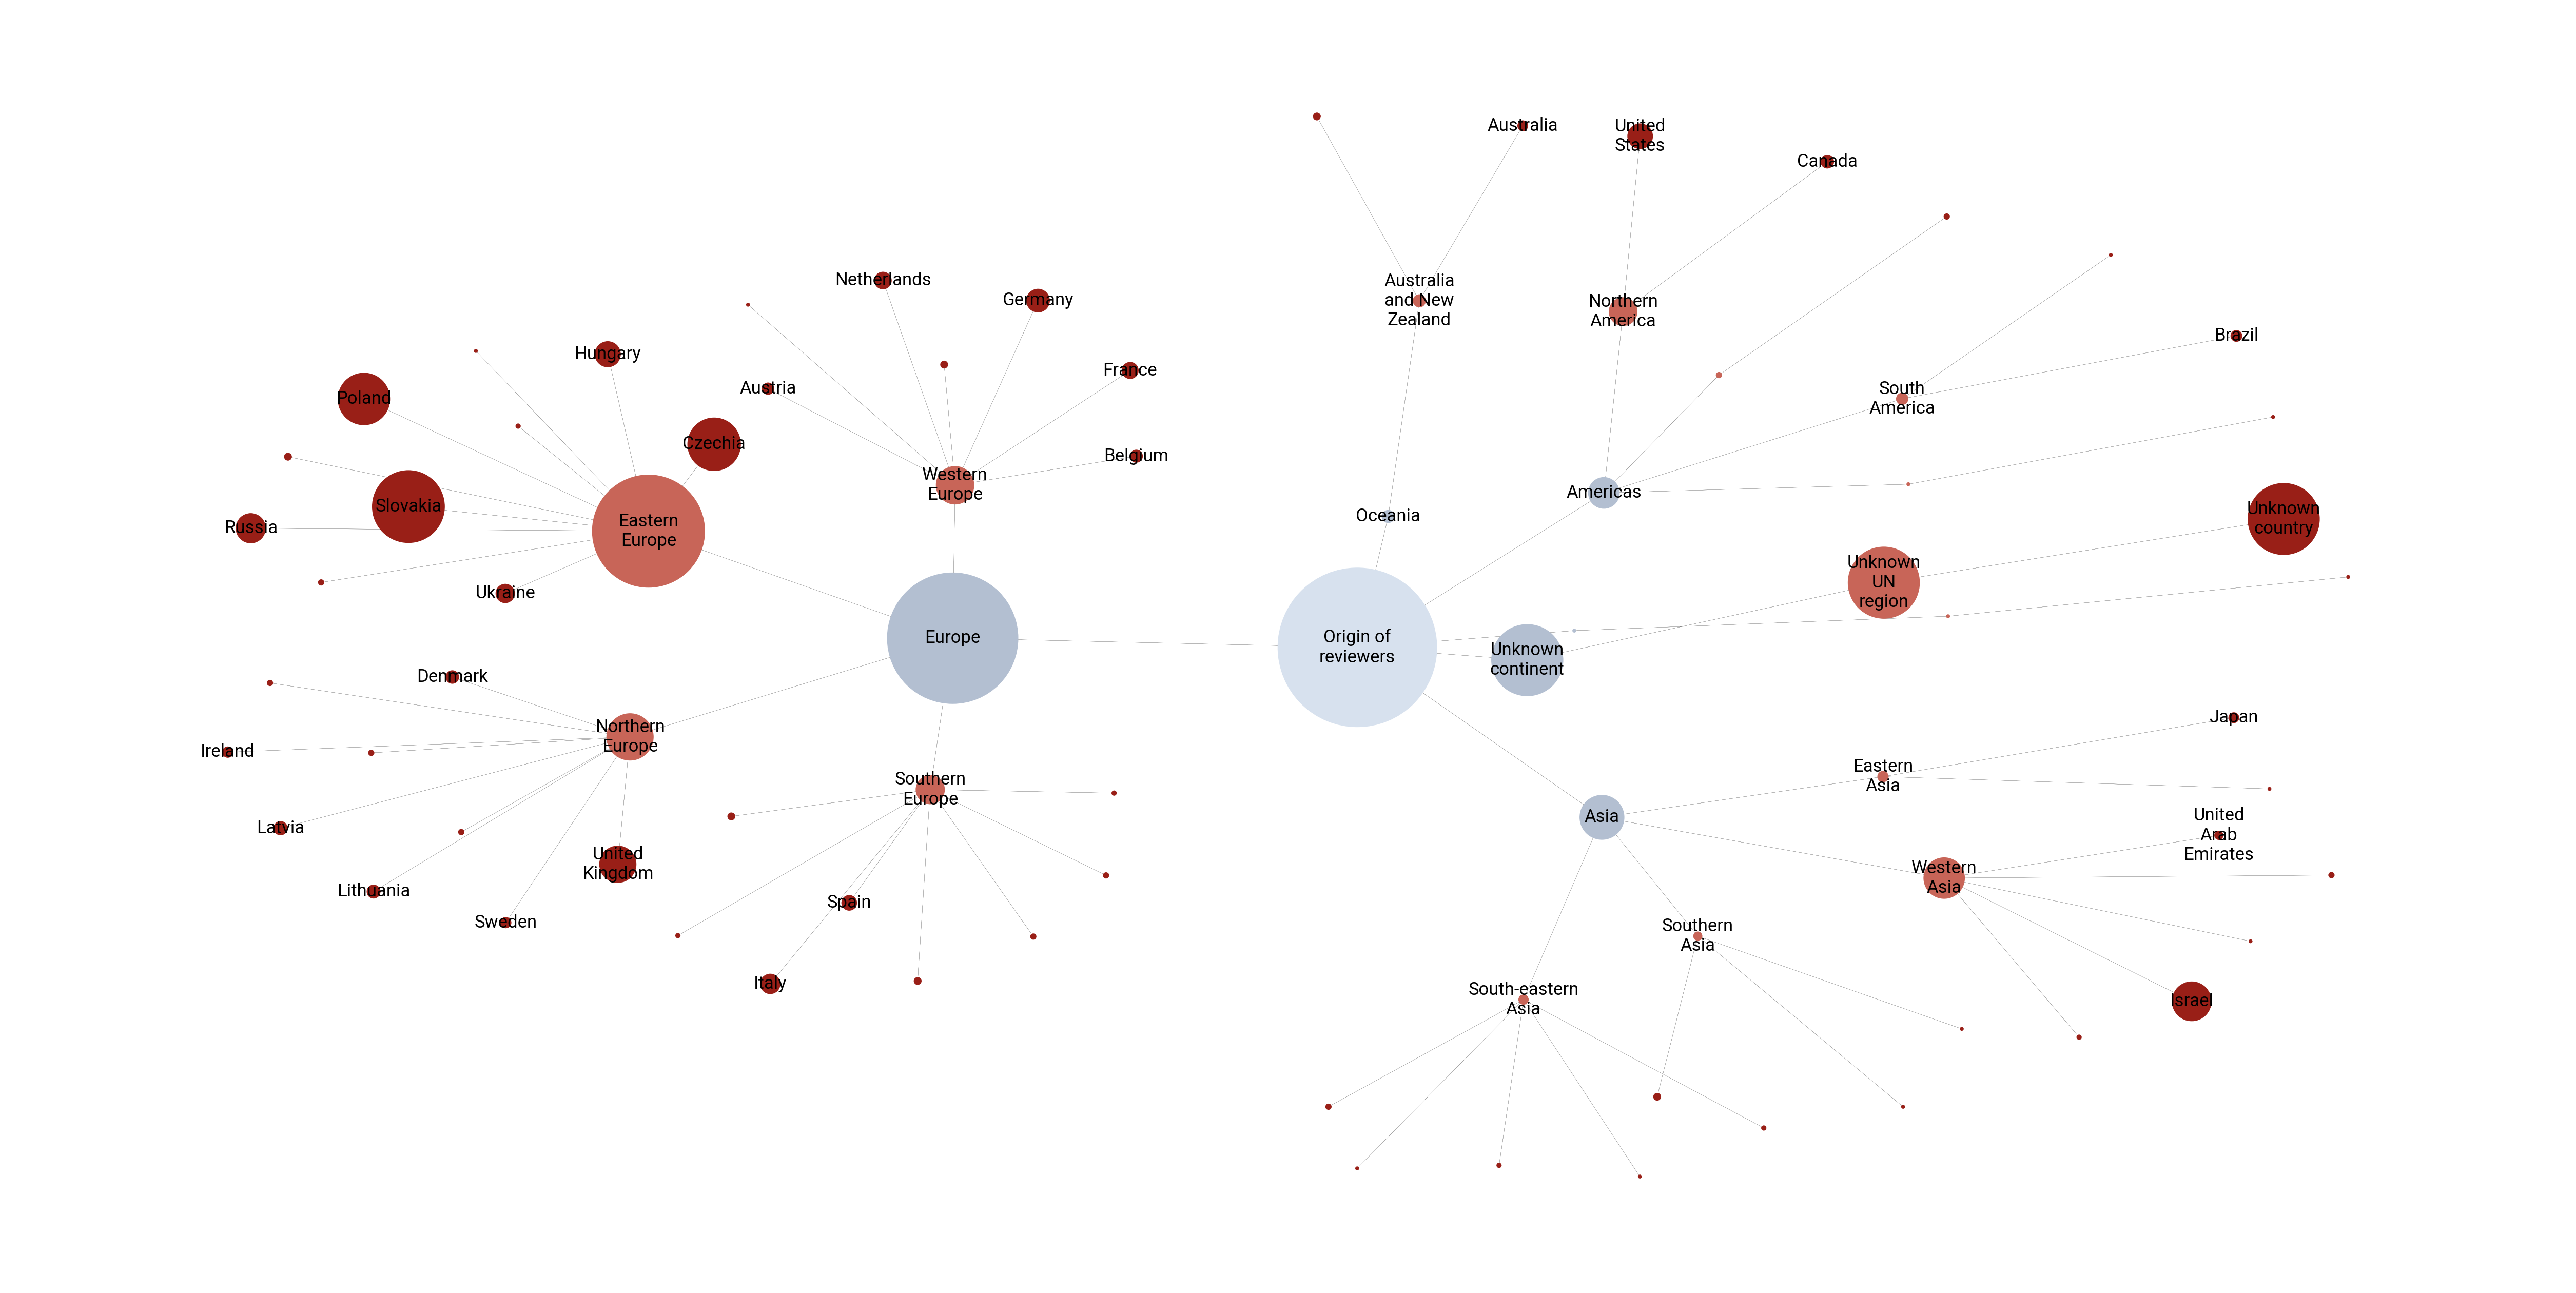

In [135]:
import pandas as pd
import networkx as nx

df_nodes = df_ndx.query('to_node != from_node')

G = nx.Graph() # Create an empty undirected graph (or nx.DiGraph() for a directed graph)
# Add edges from the DataFrame
edges = [(row['from_node'], row['to_node']) for index, row in df_nodes.iterrows()]
G.add_edges_from(edges)
# Add nodes from the 'source' and 'target' columns
G.add_nodes_from(df_nodes['from_node'])
G.add_nodes_from(df_nodes['to_node'])

df_nodes = pd.DataFrame(list(G.nodes))
df_nodes['nidx'] = df_nodes.index
df_nodes['to_node'] = df_nodes[0]
df_sizes = df_ndx.copy()
df_sizes = pd.merge(df_sizes, df_nodes, on='to_node', how='outer')
df_sizes = df_sizes.sort_values('nidx', ascending=True)
sizes_x = [x for x in df_sizes['n']] 


clrs = []
hex_clrs= ["#d7e1ee", "#cbd6e4", "#bfcbdb", "#b3bfd1", "#a4a2a8", "#df8879", "#c86558", "#b04238", "#991f17"]


for x in df_sizes['lvl'].fillna(0):
    if x == 'root':
        clrs.append(hex_clrs[0])
    elif x == 'lvl1':
        clrs.append(hex_clrs[3])
    elif x == 'lvl2':
        clrs.append(hex_clrs[6])
    elif x == 'lvl3':
        clrs.append(hex_clrs[-1])
    
  
     

    
sizes_x = [x*20 for x in sizes_x]

label_median = df_cnt['n'].median()
hubs = list(df_sizes.query('n > @label_median')['to_node'])
labels = {}    
for node in G.nodes():
    if node in hubs:
        #set the node name as the key and the label as its value 
        labels[node] = node

fig = plt.figure(figsize=(50,25)) 
pos = nx.kamada_kawai_layout(G, center=[0,0]) # Define the layout for node positioning
nx.draw(G, pos, node_size=sizes_x, node_color=clrs, width=0.2)
nx.draw_networkx_labels(G,pos,labels,font_size=25, font_color='black', font_family='Roboto', font_weight='normal')
fig.savefig("dumps/exported_figs/ta_geo_country.svg", bbox_inches="tight")

In [137]:
continet_n = df_desc.query('lvl == "lvl1" and to_node != "Unknown continent"')['n'].sum()
europe_n = df_desc.query('to_node == "Europe"')['n'].sum()
eeurope_n = df_desc.query('to_node == "Eastern Europe"')['n'].sum()

sk = df_desc.query('to_node == "Slovakia"')['n'].sum()*100/eeurope_n
cz = df_desc.query('to_node == "Czechia"')['n'].sum()*100/eeurope_n
pl = df_desc.query('to_node == "Poland"')['n'].sum()*100/eeurope_n
hu = df_desc.query('to_node == "Hungary"')['n'].sum()*100/eeurope_n
ua = df_desc.query('to_node == "Ukraine"')['n'].sum()*100/eeurope_n
au = df_desc.query('to_node == "Austria"')['n'].sum()*100/eeurope_n
rus = df_desc.query('to_node == "Russia"')['n'].sum()*100/eeurope_n

print(sk, cz, pl, hu,  au, ua, rus)


41.1764705882353 22.07896857373086 21.192586623690573 5.07655116841257 1.04754230459307 2.73972602739726 6.8493150684931505


In [127]:
df_desc.query('lvl == "lvl3"').sort_values(by=['n'], ascending=False)

,lvl,from_node,to_node,n,shr
36,lvl3,Eastern Europe,Slovakia,552,NaN
67,lvl3,Unknown UN region,Unknown country,533,NaN
30,lvl3,Eastern Europe,Czechia,279,NaN
33,lvl3,Eastern Europe,Poland,278,NaN
70,lvl3,Western Asia,Israel,164,NaN
48,lvl3,Northern Europe,United Kingdom,150,NaN
35,lvl3,Eastern Europe,Russia,85,NaN
31,lvl3,Eastern Europe,Hungary,72,NaN
39,lvl3,Northern America,United States,68,NaN
77,lvl3,Western Europe,Germany,53,NaN
